# NMF Topic Modeling with Scikit-Learn


## Module Installation

In [1]:
# Install Spacy modules, Spacy English language parsers, OCTIS and Tweet-preprocessor

!pip install spacy
!python -m spacy download en_core_web_sm

!pip install octis
!pip install delayed

!pip install tweet-preprocessor

     |████████████████████████████████| 12.0 MB 14.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 5.7 MB 27.2 MB/s 
     |████████████████████████████████| 22.3 MB 86.5 MB/s 
     |████████████████████████████████| 170 kB 63.9 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 100 kB 12.0 MB/s 
     |████████████████████████████████| 16.3 MB 815 kB/s 
     |████████████████████████████████| 24.1 MB 1.9 MB/s 
     |████████████████████████████████| 3.1 MB 36.4 MB/s 
     |████████████████████████████████| 3.3 MB 40.5 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=23336

## Module Imports

In [2]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

#OCTIS imports
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

#Text Processing imports and Custom Spacy Tokenizer
import spacy
import en_core_web_sm

from spacy.lang.en.stop_words import STOP_WORDS

# Import Tweet processing library
import preprocessor as tweet_processor

## Text Preprocessing with Spacy and Tweet-preprocessor

In [3]:
# Get the list of stop words from spacy
print(len(STOP_WORDS))
print(STOP_WORDS)


326
{'full', 'always', 'why', "'s", 'already', 'wherein', 'out', 'more', 'than', 'perhaps', 'else', 'once', 'one', 'himself', 'although', 'front', 'beside', 'some', 'somehow', 'almost', 'if', 'too', 'still', 'whereby', 'will', 'together', 'because', 'should', 'formerly', 'really', 'within', 'themselves', 'therein', 'for', 'has', 'seeming', 'across', 'an', 'during', 'put', 'whether', 'further', "'d", 'ca', 'nor', 'its', 'herein', 'be', 'at', 'therefore', 'all', 'every', 'so', 'hundred', 'not', 'those', 'how', 'besides', 'seems', 'due', 'yet', 'or', 'before', 'can', 'say', 'three', 'their', 'anyone', 'please', 'namely', 'over', 'latterly', 'make', 'using', 'everyone', 'by', 'it', 'again', 'towards', 'none', 'into', 'in', 'latter', 'n’t', 'often', 'thereafter', 'most', 'keep', 'ourselves', 'move', 'his', 'becoming', 'own', 'otherwise', 'four', 'among', 'very', 'well', '’m', 'where', "n't", 'must', 'he', 'side', 'would', 'enough', 'seemed', 'hereupon', 'third', 'does', 'have', 'behind', 'u

In [15]:
spacy_nlp = spacy.load('en')

# Add custom stopwords to Spacy
spacy_nlp.Defaults.stop_words |= {"makemeastopword"}

# Create a method called spacy_custom_tokenizer that performs custom tokenization using Spacy
# Use tweet_processor to remove @replies, hashtags and links from Tweets
# Remove stop words, punctuation and numbers using Spacy

def spacy_custom_tokenizer(document):

    #Clean Tweet using tweet_processor
    document = tweet_processor.clean(document)

    # Creating a spacy document
    spacy_doc = spacy_nlp(document)

    # Remove stop words, punctuation and numbers
    # Return he lemma of the word as lowercase and remove extra spaces
    tokens = [word.lemma_.lower().strip() for word in spacy_doc if (not word.is_stop and not word.is_punct and not word.like_num)]

    return tokens

#Test the custom tokenizer
spacy_custom_tokenizer("I was running so I ran to run to somewhere now in Australia. ... --- makemeastopword @aneesha")

['run', 'run', 'run', 'australia']

## Load Tweets for "US Airways" from the https://www.kaggle.com/crowdflower/twitter-airline-sentiment dataset



In [6]:
# Upload dataset to Google Colab

from google.colab import files

uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [7]:
# Use pandas to load and only include tweets from "US Airways"

import pandas as pd

dataset_df = pd.read_csv('Tweets.csv')

dataset_df = dataset_df[dataset_df['airline']=='US Airways']

documents = dataset_df['text'].tolist()

dataset_df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8966,570310600460525568,negative,0.6292,Flight Booking Problems,0.3146,US Airways,NaN,jhazelnut,NaN,0,@USAirways is there a better time to call? My...,NaN,2015-02-24 11:53:37 -0800,NaN,NaN
8967,570310144459972608,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,GAKotsch,NaN,0,@USAirways and when will one of these agents b...,NaN,2015-02-24 11:51:48 -0800,NaN,Atlantic Time (Canada)
8968,570309340952993796,neutral,1.0000,NaN,NaN,US Airways,NaN,DebbiMcGinnis,NaN,0,@USAirways is a DM possible if you aren't foll...,NaN,2015-02-24 11:48:37 -0800,Missourah,Hawaii
8969,570309000279023616,neutral,1.0000,NaN,NaN,US Airways,NaN,AshleyKAtherton,NaN,0,@USAirways Fortunately you have staff like Lyn...,NaN,2015-02-24 11:47:16 -0800,NaN,Central Time (US & Canada)
8970,570308799950692353,negative,1.0000,Customer Service Issue,0.6452,US Airways,NaN,retardedlarry,NaN,0,@USAirways just hung up on me again. Another ...,NaN,2015-02-24 11:46:28 -0800,NaN,NaN


##Helper Methods

---



In [8]:

# Create a function to display both top words and top documents in a topic
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    #The method needs to take H, W, the full vocabulary, docuemnt dataset anf the number of words as a 
    # parameters and print out the top documents in addition to the top words.
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(str(doc_index) + ". " + documents[doc_index])

# Format topic output for use by OCTIS
def format_topics_for_OCTIS(nmf_H, nmf_W, vocab, no_top_words):
  topics = []
  for topic_idx, topic in enumerate(nmf_H):
    word_list = [vocab[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    topics.append(word_list)

  octis_topic_dict = {}
  octis_topic_dict["topic-word-matrix"] = nmf_H
  octis_topic_dict["topics"] = topics
  octis_topic_dict["topic-document-matrix"] = np.array(nmf_W).transpose()
  return octis_topic_dict

# Recreate the dataset for OCTIS using the spacy_custom_tokenizer
def get_dataset_for_octis(documents):
  dataset_for_octis = []
  for document in documents:
    dataset_for_octis.append(spacy_custom_tokenizer(document))
  return dataset_for_octis


## Parameters to Set

In [16]:
no_topics_list = list(range(4, 40)) #Todo: Set range of topics to be evaluated
no_top_words = 10 #Todo: Set number of top words - will be used by Diversity and display_topics() method
no_top_documents = 10 #Todo: Set number of top documents - will be used by the display_topics() method

spacy_nlp.Defaults.stop_words |= {'flight', '..', '...', '....', 'help', 'thank', 'thanks','great', 'need', 'response', 'today'}

max_iter = 500

##Create a TfidfVectorizer that uses the custom Spacy Tokenizer

In [18]:
# TF-IDF stands for Term Frequency-Inverse Document Frequency. TF-IDF is a technique that is used to normalize the raw word counts in comparison to the document frequency. 
# TF-IDF is used to represent how important a word is in a document based on how many times the word appears in the current document and how many other documents also contain the word. 
# A higher TF-IDF score indicates higher importance for the word in the document.

# max_df - ignore terms that have a document frequency higher than the given threshold (corpus-specific stop words). This parameter represents a proportion of documents.
# min_df - ignore terms that have a document frequency lower than the given threshold. In range of [0.0, 1.0], the parameter represents a proportion of documents.
# max_features - only consider the top max_features ordered by term frequency across the corpus.

tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_custom_tokenizer, max_features=2000, max_df=0.95, min_df=10)
term_document_matrix = tfidf_vectorizer.fit_transform(documents)
vocab = tfidf_vectorizer.get_feature_names()


## Vary the Number of Topics and Calculate Coherence and Diversity

In [19]:
reconstruction_error_list = []
number_of_iterations_list = []
npmi_coherence_score_list = []
diversity_score_list = []

# Coherence measures the semantic similarity between words in a topic and the metric can be reported across all topics that are generated by a Topic Modeling algorithm. 
# Normalized Pointwise Mutual Information (NPMI) score will be used as a Coherence measure. 
# NPMI measures how much more likely the top words in a generated topic can co-occur than if they were independent within the provided corpus.
npmi = Coherence(texts=get_dataset_for_octis(documents), topk=no_top_words, measure='c_npmi')

# Diversity is a measure of the uniqueness of words in a topic and is calculated between all generated topics.
topic_diversity = TopicDiversity(topk=no_top_words)

for no_topics in no_topics_list:

  curent_no_topics = no_topics
  nmf_model = NMF(n_components=curent_no_topics, init='nndsvd', max_iter=max_iter).fit(term_document_matrix)
  nmf_W = nmf_model.transform(term_document_matrix)
  nmf_H = nmf_model.components_

  reconstruction_error_list.append(nmf_model.reconstruction_err_)
  number_of_iterations_list.append(nmf_model.n_iter_)

  octis_topic_dict = format_topics_for_OCTIS(nmf_H, nmf_W, vocab, no_top_words)

  npmi_coherence_score_list.append(npmi.score(octis_topic_dict))
  diversity_score_list.append(topic_diversity.score(octis_topic_dict))


print("reconstruction_error_list", reconstruction_error_list)
print("number_of_iterations_list", number_of_iterations_list)
print("npmi_coherence_score_list", npmi_coherence_score_list)
print("diversity_score_list", diversity_score_list)


reconstruction_error_list [51.24051812582791, 50.942658182911195, 50.67193150805949, 50.39895677060591, 50.16382525447004, 49.922523540269125, 49.6922215836967, 49.47160282320441, 49.27596675110744, 49.019992862265745, 48.80350397454866, 48.62441912087162, 48.386453031914556, 48.196681145822666, 47.97087312778232, 47.78515915118506, 47.54980800724205, 47.3541420201889, 47.16599241020493, 46.989558399295554, 46.80230531402132, 46.629061749728095, 46.45714217444255, 46.25207097688603, 46.07133309310334, 45.9058928988189, 45.72559336286115, 45.59881894374744, 45.39506045186217, 45.2386446285017, 45.07122040203292, 44.93084820070871, 44.75910589605674, 44.57425934244373, 44.39437972688001, 44.283146642564866]
number_of_iterations_list [60, 46, 76, 48, 45, 70, 104, 76, 209, 163, 66, 136, 338, 84, 240, 317, 122, 57, 170, 214, 144, 155, 156, 120, 317, 157, 150, 85, 138, 164, 84, 103, 143, 106, 185, 106]
npmi_coherence_score_list [-0.0009744669222551444, 0.022443641394622904, 0.017191003401957

## Plot the Coherence and Diversity Metric



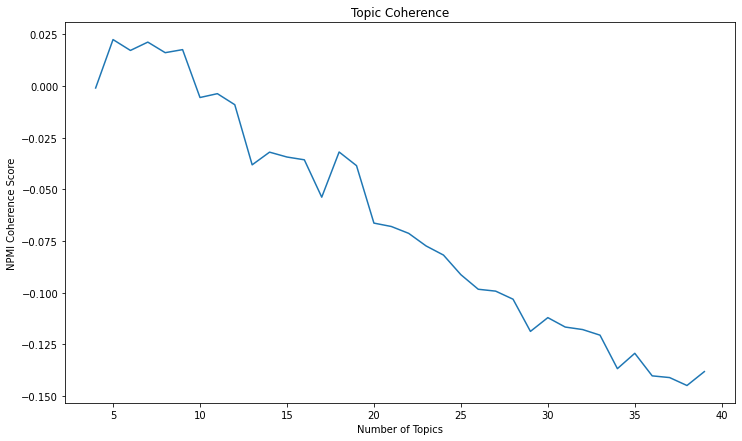

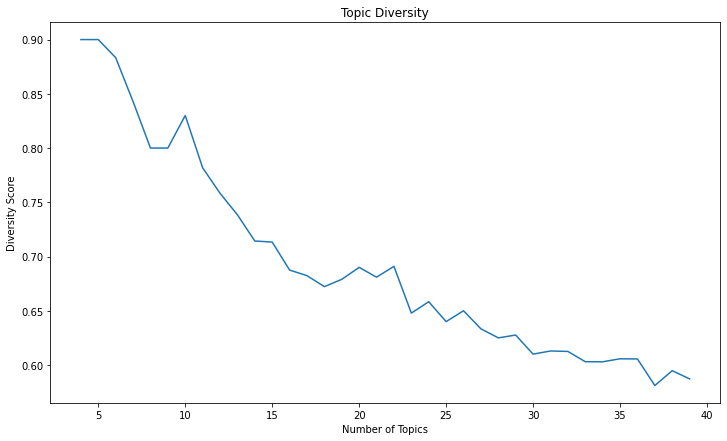

In [20]:

plt.figure(figsize=(12,7))
plt.plot(no_topics_list, npmi_coherence_score_list)  

plt.xlabel("Number of Topics")
plt.ylabel("NPMI Coherence Score")
plt.title("Topic Coherence")

plt.show()

plt.figure(figsize=(12,7))
plt.plot(no_topics_list, diversity_score_list)  

plt.xlabel("Number of Topics")
plt.ylabel("Diversity Score")
plt.title("Topic Diversity")

plt.show()

## Run NMF for the Selected Number of Topics and Visualize

In [21]:
  
selected_number_of_topics = 10
nmf_model = NMF(n_components=selected_number_of_topics, init='nndsvd', max_iter=max_iter).fit(term_document_matrix)
nmf_W = nmf_model.transform(term_document_matrix)
nmf_H = nmf_model.components_

display_topics(nmf_H, nmf_W, vocab, documents, no_top_words, no_top_documents)

Topic 0:
hold (3.24) hour (2.87) minute (1.06) try (0.33) reservation (0.31) + (0.29) min (0.27) count (0.24) change (0.22) unacceptable (0.17)
869. @USAirways been on hold for over and hour now.
1408. @USAirways @AmericanAir how do I get thru on hold over 3 hours ?
997. @usairways I have been on hold for over 3 hours.  Please help! http://t.co/tyXAZtMQ1U
476. @USAirways anyone there to help? Still on hold...
1226. @USAirways GF was on hold for 4 hours and call was dropped!!! HELP!!!!! Need a flight!!!
774. @USAirways - been on hold for more than 2.5 hours - this after not getting through after 2 hours on hold this morning with no answer - help!
1096. @USAirways on hold 2 hours 54 minutes. What's going on?
1411. @USAirways how do I get thru on hold 3 hours 5 minutes . Is this normal ? My call is lost
254. @USAirways   Not good. On hold for over an hour. http://t.co/wSgYckCIIO
1352. @USAirways @jtrexsocial 5 hours on hold ... Safe to say no one is working .
Topic 1:
service (1.63) custo